In [1]:
!nvidia-smi

Sat Nov  6 19:24:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip /content/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/without_mask/without_mask_2202.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_2202.jpg  
  inflating: data/without_mask/without_mask_620.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_620.jpg  
  inflating: data/without_mask/without_mask_146.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_146.jpg  
  inflating: data/without_mask/without_mask_2564.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_2564.jpg  
  inflating: data/without_mask/without_mask_79.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_79.jpg  
  inflating: data/without_mask/without_mask_2955.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_2955.jpg  
  inflating: data/without_mask/without_mask_3493.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_3493.jpg  
  inflating: data/without_mask/without_mask_1284.jpg  
  inflating: __MACOSX/data/without_mask/._without_mask_

In [2]:

import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [3]:
CFG = {
    'train_BS': 128,
    'valid_BS': 128,
    'lr': 0.01,
    'grad_clip': 0.1,
    'weight_decay': 0.01,
    'epochs': 30,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [5]:
from torchvision.datasets import ImageFolder

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(0.2),
     transforms.Resize((32,32)),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
dataset = ImageFolder('data/', transform=transform) 

# data = pd.read_csv('/content/masked_unmasked/data.csv')
# data = data.drop(data[data['image'] == "masked/.DS_Store"].index)

# train, valid = train_test_split(data, test_size=0.15, random_state=42)

In [54]:
from torch.utils.data import Subset
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    train = Subset(dataset, train_idx)
    valid = Subset(dataset, val_idx)
    return train, valid

train_data, valid_data = train_val_dataset(dataset, 0.2)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG['train_BS'], shuffle=True, pin_memory=False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG['valid_BS'], shuffle=False, pin_memory=False)

In [79]:
x, y = iter(train_loader).next()

In [81]:
y

tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0])

In [55]:
# class MaskDataset(torch.utils.data.Dataset):
#     def __init__ (self, csv_data, images_path, transform=None):
#         self.csv_data = csv_data
#         self.transform = transform
#         self.images_path = images_path
    
#     def __len__ (self):
#         return self.csv_data.shape[0]
    
#     def __getitem__ (self, idx):
#         label = 1 if self.csv_data.iloc[idx, 1] == "masked" else 0
#         image = cv2.imread(os.path.join(self.images_path, self.csv_data.iloc[idx, 0]))
#         if image is None:
#             print(idx)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         if self.transform is not None:
#             image = self.transform(image)
#         return image, label

In [56]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.RandomHorizontalFlip(0.2),
#      transforms.Resize(32,32),
#      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
# )

# train_data = MaskDataset(train, '/content/masked_unmasked', transform=transform)
# valid_data = MaskDataset(valid, '/content/masked_unmasked', transform=transform)

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG['train_BS'], shuffle=True, pin_memory=False)
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG['valid_BS'], shuffle=False, pin_memory=False)

In [57]:
import os
import torch
import torch.nn as nn
import numpy as np
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score

class Train:
    def __init__ (self, model, device, optimizer, criterion, scheduler=None):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.model.to(self.device)
        self.scheduler = scheduler
        # self.x = []

    def train (self, train_loader, epoch, n_examples):
        self.model.train()
        # training_loss = 0
        losses = []
        predicts = []
        correct = []
        description = "\nEPOCH: {} training".format(epoch+1)
        train_bar = tq.tqdm(train_loader, total=len(train_loader), desc=description, position=0, leave=True)
        for images, labels in train_bar:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(images)
            loss = self.criterion(output, labels)

            correct.extend(labels.cpu().numpy())
            predicts.extend(torch.argmax(output, dim=1).cpu().numpy())
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.optimizer.zero_grad()
  
            train_bar.set_postfix(loss=np.mean(losses))
        return np.mean(losses), accuracy_score(predicts, correct)

    def val (self, val_loader, epoch, n_examples):
        self.model.eval()
        losses = []
        predicts = []
        correct = []
        description = "EPOCH: {} validation".format(epoch+1)
        with torch.no_grad():
            valid_bar = tq.tqdm(val_loader, total=len(val_loader), desc=description, position=0, leave=True)
            for images, labels in valid_bar:

                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                loss = self.criterion(output, labels)

                correct.extend(labels.cpu().numpy())
                predicts.extend(torch.argmax(output, dim=1).cpu().numpy())

                losses.append(loss.item())
                valid_bar.set_postfix(loss=np.mean(losses))

        return np.mean(losses), accuracy_score(predicts, correct)


    def learning_rate(self, optimizer):
        for params in optimizer.param_groups:
            return param_group['lr']
    
    def fit(self, ES, model_path, train_loader, val_loader=None, epochs=1, start_epoch=0, fold=0, train_BS=64, valid_BS=64, grad_clip=None):
        
        training_loss_lst = []
        training_acc_lst = []
        val_loss_lst = []
        val_acc_lst = []
        i = 0
        validation = False

        # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        if val_loader is not None:
            validation = True
            # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

        # print("=> Trining Model on: {}\n\n".format(self.device))
        min_loss = np.Inf
        for epoch in range(start_epoch, epochs):
            
            training_loss, training_acc = self.train(train_loader, epoch, len(train_loader)*train_BS)
            training_loss_lst.append(training_loss)
            training_acc_lst.append(training_acc)
            
            if validation:
                val_loss, val_acc = self.val(val_loader, epoch, len(val_loader)*valid_BS)
                val_loss_lst.append(val_loss)
                val_acc_lst.append(val_acc)

                # self.x.append([training_loss, training_acc, val_loss, val_acc])
                print('Train Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(training_loss, training_acc, val_loss, val_acc))
                i += 1
                if i > ES:
                    print('\nEarly Stopping')
                    break
                if val_loss <= min_loss:
                    i = 0
                    if self.scheduler is not None:
                        checkpoint = {
                              'epoch': epoch + 1,
                              'model': self.model.state_dict(),
                              'optimizer': self.optimizer.state_dict(),
                              'scheduler': self.scheduler.state_dict()
                          }
                    else:
                        checkpoint = {
                              'epoch': epoch + 1,
                              'model': self.model.state_dict(),
                              'optimizer': self.optimizer.state_dict()
                          }
                    

                    model_path_1 = os.path.join(model_path, 'model_fold{}.pt'.format(fold))
                    torch.save(checkpoint, model_path_1)
                    print('\nVal loss decreased ({:.4f} -> {:.4f}), Model saved'.format(min_loss, val_loss))
                    min_loss = val_loss
                    
            
            else:
                print('EPOCH: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} '.format(epoch+1, training_loss, training_acc))
                i += 1
                if i >= ES:
                    print('Early Stopping')
                    break
                if training_loss <= min_loss:
                    i = 0
                    print('Loss decreased ({:.4f} -> {:.4f}), model saved at {}'.format(min_loss, training_loss, model_path))
                    min_loss = training_loss

                    if self.scheduler is not None:
                        checkpoint = {
                            'epoch': epoch + 1,
                            'model': self.model.state_dict(),
                            'optimizer': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict()
                        }
                    else:
                        checkpoint = {
                        'epoch': epoch + 1,
                        'model': self.model.state_dict(),
                        'optimizer': self.optimizer.state_dict()
                    }
                    model_path_1 = '{}model_{}.pt'.format(model_path, epoch+1)
                    torch.save(checkpoint, model_path_1)
            
            if self.scheduler is not None:
                self.scheduler.step()

            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            torch.cuda.empty_cache()

        history = {
            'train_loss': training_loss_lst,
            'train_acc': training_acc_lst,
            'val_loss': val_loss_lst,
            'val_acc': val_acc_lst
        }

        return history   

In [9]:
class MaskClassifierResnet34(nn.Module):
    def __init__ (self, opt_class):
        super().__init__ ()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, opt_class)
    
    def forward (self, image):
        return self.resnet(image)

# class MaskClassifierMobileNetV2(nn.Module):
#     def __init__ (self, opt_class):
#         super().__init__ ()
#         self.mobnet = torchvision.models.mobilenet_v2(pretrained=True)
#         self.mobnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False), nn.Linear(1280, 2))
    
#     def forward (self, image):
#         return self.mobnet(image)

In [59]:
# resnet = torchvision.models.mobilenet_v2(pretrained=True)
# resnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False), nn.Linear(1280, 2))
# resnet

In [60]:
model = MaskClassifierResnet34(2)
model = model.to(CFG['device'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))

In [61]:
trainer = Train(model=model, device=CFG['device'], optimizer=optimizer, criterion=criterion, scheduler=scheduler)

In [62]:
trainer.fit(ES=3, model_path='../content', train_loader=train_loader, val_loader=valid_loader, epochs=CFG['epochs'], start_epoch=0, fold=0, train_BS=CFG['train_BS'], valid_BS=CFG['train_BS'], grad_clip=CFG['grad_clip'])


EPOCH: 1 training:   0%|          | 0/48 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 1 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2349 	Train Acc: 0.8967 	Val Loss: 0.0932 	Val Acc: 0.9722

Val loss decreased (inf -> 0.0932), Model saved



EPOCH: 2 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 2 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0821 	Train Acc: 0.9717 	Val Loss: 0.0849 	Val Acc: 0.9722

Val loss decreased (0.0932 -> 0.0849), Model saved



EPOCH: 3 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 3 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0595 	Train Acc: 0.9810 	Val Loss: 0.0737 	Val Acc: 0.9735

Val loss decreased (0.0849 -> 0.0737), Model saved



EPOCH: 4 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 4 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0394 	Train Acc: 0.9874 	Val Loss: 0.0736 	Val Acc: 0.9768

Val loss decreased (0.0737 -> 0.0736), Model saved



EPOCH: 5 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 5 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0249 	Train Acc: 0.9934 	Val Loss: 0.0812 	Val Acc: 0.9788



EPOCH: 6 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 6 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0173 	Train Acc: 0.9934 	Val Loss: 0.0522 	Val Acc: 0.9868

Val loss decreased (0.0736 -> 0.0522), Model saved



EPOCH: 7 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 7 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0156 	Train Acc: 0.9954 	Val Loss: 0.0855 	Val Acc: 0.9801



EPOCH: 8 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 8 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0133 	Train Acc: 0.9959 	Val Loss: 0.0680 	Val Acc: 0.9795



EPOCH: 9 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 9 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0173 	Train Acc: 0.9955 	Val Loss: 0.0628 	Val Acc: 0.9821



EPOCH: 10 training:   0%|          | 0/48 [00:00<?, ?it/s]

EPOCH: 10 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0139 	Train Acc: 0.9960 	Val Loss: 0.0599 	Val Acc: 0.9828

Early Stopping


{'train_acc': [0.23486423213034868,
  0.8967229394240318,
  0.08209981575297813,
  0.9716981132075472,
  0.05953120135624582,
  0.9809665673618008,
  0.03941391171732297,
  0.9874213836477987,
  0.024926182345855825,
  0.9933796756041046,
  0.01734145738737425,
  0.9933796756041046,
  0.01562845269169581,
  0.9953657729228732,
  0.013322545257324236,
  0.9958622972525654,
  0.017271558109011192,
  0.9955312810327706,
  0.01394579524276196,
  0.9960278053624627],
 'train_loss': [],
 'val_acc': [0.972203838517538,
  0.972203838517538,
  0.9735274652547982,
  0.9768365320979484,
  0.9788219722038385,
  0.986763732627399,
  0.9801455989410987,
  0.9794837855724685,
  0.9821310390469887,
  0.9827928524156188],
 'val_loss': [0.09324903072168429,
  0.08486713950211804,
  0.07372244509557883,
  0.0736177663008372,
  0.08116284443531185,
  0.05217760005810609,
  0.08549400814808905,
  0.06797199643915519,
  0.06283752736635506,
  0.059889239278466753]}

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
model = torch.load("model_fold0.pt")['model']
resnet = MaskClassifierResnet34(2)
resnet.load_state_dict(model)
resnet = resnet.to(CFG['device'])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [48]:
labels_list = ['masked', 'unmasked']

def find_face(img):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if faces is None:
        return None
    for (x, y, w, h) in faces:
        img = img[y:y+h, x:x+w]
    return img

def pred_label(img, model, labels_list):
    img  = find_face(img)
    if img is None:
        return "No face found"
    img = transform(img)
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(CFG['device']))
    print(pred)
    return labels_list[pred.argmax(1).data[0]]

In [17]:
!wget https://static01.nyt.com/images/2020/04/10/video/HowToMakeAMask_Cover_1/HowToMakeAMask_Cover_1-square640.jpg

--2021-11-06 19:56:53--  https://static01.nyt.com/images/2020/04/10/video/HowToMakeAMask_Cover_1/HowToMakeAMask_Cover_1-square640.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66512 (65K) [image/jpeg]
Saving to: ‘HowToMakeAMask_Cover_1-square640.jpg’

HowToMakeAMask_Cove 100%[===================>]  64.95K  --.-KB/s    in 0.01s   

2021-11-06 19:56:53 (5.64 MB/s) - ‘HowToMakeAMask_Cover_1-square640.jpg’ saved [66512/66512]



tensor([[ 7.3103, -8.0928]], device='cuda:0')


'masked'

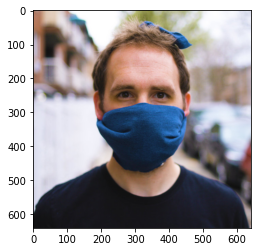

In [41]:
img = cv2.imread('/content/HowToMakeAMask_Cover_1-square640.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(find_face(img), resnet, labels_list)

In [46]:
!wget https://www.onemedical.com/media/images/woman-wearing-mask.width-1440.jpg

--2021-11-06 20:22:25--  https://www.onemedical.com/media/images/woman-wearing-mask.width-1440.jpg
Resolving www.onemedical.com (www.onemedical.com)... 54.230.15.52, 54.230.15.65, 54.230.15.102, ...
Connecting to www.onemedical.com (www.onemedical.com)|54.230.15.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123938 (121K) [image/jpeg]
Saving to: ‘woman-wearing-mask.width-1440.jpg’

woman-wearing-mask. 100%[===================>] 121.03K   783KB/s    in 0.2s    

2021-11-06 20:22:26 (783 KB/s) - ‘woman-wearing-mask.width-1440.jpg’ saved [123938/123938]



tensor([[ 6.4332, -8.1674]], device='cuda:0')


'masked'

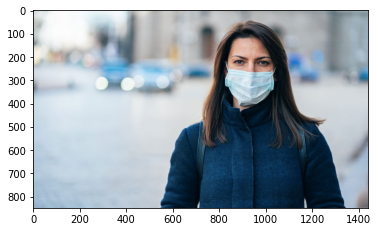

In [49]:
img = cv2.imread('/content/woman-wearing-mask.width-1440.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(find_face(img), resnet, labels_list)

In [50]:
!wget https://i.ndtvimg.com/i/2016-11/sheldon_640x480_41478610926.jpg

--2021-11-06 20:23:25--  https://i.ndtvimg.com/i/2016-11/sheldon_640x480_41478610926.jpg
Resolving i.ndtvimg.com (i.ndtvimg.com)... 23.11.225.25, 2600:1407:d800:19d::24e8, 2600:1407:d800:18f::24e8
Connecting to i.ndtvimg.com (i.ndtvimg.com)|23.11.225.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30852 (30K) [image/jpeg]
Saving to: ‘sheldon_640x480_41478610926.jpg.1’

sheldon_640x480_414 100%[===================>]  30.13K  --.-KB/s    in 0.01s   

2021-11-06 20:23:25 (2.57 MB/s) - ‘sheldon_640x480_41478610926.jpg.1’ saved [30852/30852]



tensor([[-4.9414,  3.3228]], device='cuda:0')


'unmasked'

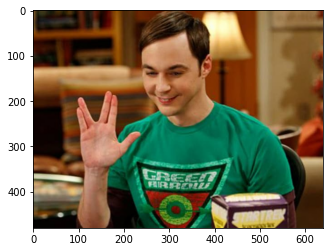

In [51]:
img = cv2.imread('/content/sheldon_640x480_41478610926.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(find_face(img), resnet, labels_list)

In [52]:
!wget https://www.mayoclinichealthsystem.org/-/media/national-files/images/hometown-health/2020/person-wearing-a-mask.jpg?h=370&w=660&la=en&hash=1C2BCBE2AE429A4850802B1CB340E79F

--2021-11-06 20:23:43--  https://www.mayoclinichealthsystem.org/-/media/national-files/images/hometown-health/2020/person-wearing-a-mask.jpg?h=370
Resolving www.mayoclinichealthsystem.org (www.mayoclinichealthsystem.org)... 23.35.71.24, 2600:1407:d800::1723:4718
Connecting to www.mayoclinichealthsystem.org (www.mayoclinichealthsystem.org)|23.35.71.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57392 (56K) [image/jpeg]
Saving to: ‘person-wearing-a-mask.jpg?h=370’

person-wearing-a-ma 100%[===================>]  56.05K  --.-KB/s    in 0.01s   

2021-11-06 20:23:43 (3.87 MB/s) - ‘person-wearing-a-mask.jpg?h=370’ saved [57392/57392]



tensor([[-5.3252,  3.5935]], device='cuda:0')


'unmasked'

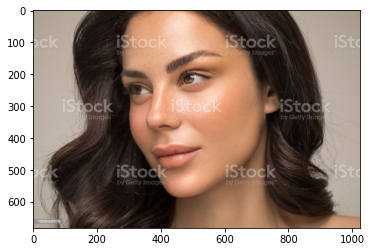

In [54]:
img = cv2.imread('/content/istockphoto-1309405076-1024x1024.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(find_face(img), resnet, labels_list)